# Forecast Harga Pasar Komoditas Bawang Merah di Brebes

## Import Libraries

In [141]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow import keras
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Flatten

## Data Collections

In [142]:
file_path = "dataset.csv"
df = pd.read_csv(file_path)
df

,Komoditas (Rp),15/03/2021,16/03/2021,17/03/2021,18/03/2021,19/03/2021,20/03/2021,21/03/2021,22/03/2021,23/03/2021,...,30/11/2024,01/12/2024,02/12/2024,03/12/2024,04/12/2024,05/12/2024,06/12/2024,07/12/2024,08/12/2024,09/12/2024
0,Beras Premium,11.500,11.500,11.500,11.500,11.500,11.500,-,11.500,-,...,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0
1,Beras Medium,9.000,9.000,9.000,9.000,9.000,9.000,-,9.000,-,...,13.5,13.5,13.5,13.5,13.5,13.5,13.5,13.5,13.5,13.5
2,Kedelai Biji Kering (Impor),11.000,11.000,11.000,11.000,11.000,11.000,-,10.000,-,...,10.3,10.3,10.3,10.3,10.3,10.3,10.3,10.3,10.3,10.3
3,Bawang Merah,28.000,28.000,28.000,28.000,28.000,27.000,-,27.000,-,...,35.0,35.0,35.0,33.0,33.0,32.0,32.0,32.0,32.0,32.0
4,Bawang Putih Bonggol,22.000,22.000,22.000,22.000,22.000,22.000,-,22.000,-,...,35.0,35.0,35.0,35.0,35.0,35.0,35.0,35.0,35.0,35.0
5,Cabai Merah Keriting,50.000,50.000,50.000,50.000,50.000,50.000,-,50.000,-,...,18.0,18.0,22.0,22.0,22.0,24.0,24.0,24.0,24.0,32.0
6,Cabai Rawit Merah,115.000,115.000,115.000,115.000,110.000,115.000,-,115.000,-,...,32.0,32.0,35.0,35.0,35.0,35.0,35.0,35.0,35.0,40.0
7,Daging Sapi Murni,120.000,120.000,120.000,120.000,120.000,120.000,-,120.000,-,...,143.0,143.0,143.0,143.0,143.0,143.0,143.0,143.0,143.0,143.0
8,Daging Ayam Ras,36.000,36.000,36.000,36.000,36.000,36.000,-,36.000,-,...,39.0,39.0,39.0,39.0,39.0,40.0,40.0,40.0,40.0,40.0
9,Telur Ayam Ras,22.000,22.000,22.000,22.000,22.000,22.000,-,22.000,-,...,27.0,27.0,27.0,26.0,27.0,26.0,26.0,26.0,26.0,28.0


## Data Cleaning

In [143]:
# Menambah label "tanggal" ke dalam list kolom
kolom = ["tanggal"] + [x.strip() for x in df[" Komoditas (Rp) "]]

# Ubah nama kolom pada df_transformed sesuai dengan kolom yang diinginkan
df_transformed = df.set_index(" Komoditas (Rp) ").T.reset_index()

df_transformed.columns = kolom
# mengubah tanggal menjadi tipe data tanggal
df_transformed['tanggal'] = pd.to_datetime(df_transformed['tanggal'], format='%d/%m/%Y')

# Mengganti nilai kosong atau tanda tertentu dengan NaN
df_transformed.replace(["", "-", " "], np.nan, inplace=True)

# Mengonversi kolom data (selain tanggal) menjadi float
for col in df_transformed.columns[1:]:  # Mulai dari indeks 1 agar kolom 'tanggal' tidak diubah
    df_transformed[col] = pd.to_numeric(df_transformed[col], errors='coerce') * 1000

# Memeriksa apakah perubahan berhasil
print(df_transformed.dtypes)
print(df_transformed.isnull().sum())
df_transformed

tanggal                              datetime64[ns]
Beras Premium                               float64
Beras Medium                                float64
Kedelai Biji Kering (Impor)                 float64
Bawang Merah                                float64
Bawang Putih Bonggol                        float64
Cabai Merah Keriting                        float64
Cabai Rawit Merah                           float64
Daging Sapi Murni                           float64
Daging Ayam Ras                             float64
Telur Ayam Ras                              float64
Gula Konsumsi                               float64
Minyak Goreng Kemasan Sederhana             float64
Tepung Terigu (Curah)                       float64
Minyak Goreng Curah                         float64
Jagung Tk Peternak                          float64
Ikan Kembung                                float64
Ikan Tongkol                                float64
Ikan Bandeng                                float64
Garam Halus 

C:\Users\ACER\AppData\Local\Temp\ipykernel_5800\1358906317.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_transformed.replace(["", "-", " "], np.nan, inplace=True)


,tanggal,Beras Premium,Beras Medium,Kedelai Biji Kering (Impor),Bawang Merah,Bawang Putih Bonggol,Cabai Merah Keriting,Cabai Rawit Merah,Daging Sapi Murni,Daging Ayam Ras,...,Minyak Goreng Kemasan Sederhana,Tepung Terigu (Curah),Minyak Goreng Curah,Jagung Tk Peternak,Ikan Kembung,Ikan Tongkol,Ikan Bandeng,Garam Halus Beryodium,Tepung Terigu Kemasan (non-curah),Beras SPHP
0,2021-03-15,11500.0,9000.0,11000.0,28000.0,22000.0,50000.0,115000.0,120000.0,36000.0,...,14000.0,7000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-03-16,11500.0,9000.0,11000.0,28000.0,22000.0,50000.0,115000.0,120000.0,36000.0,...,14000.0,7000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-03-17,11500.0,9000.0,11000.0,28000.0,22000.0,50000.0,115000.0,120000.0,36000.0,...,14000.0,7000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2021-03-18,11500.0,9000.0,11000.0,28000.0,22000.0,50000.0,115000.0,120000.0,36000.0,...,14000.0,7000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2021-03-19,11500.0,9000.0,11000.0,28000.0,22000.0,50000.0,110000.0,120000.0,36000.0,...,14000.0,7000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1361,2024-12-05,15000.0,13500.0,10300.0,32000.0,35000.0,24000.0,35000.0,143000.0,40000.0,...,18000.0,9000.0,17000.0,5100.0,30000.0,30000.0,33000.0,10000.0,12000.0,12000.0
1362,2024-12-06,15000.0,13500.0,10300.0,32000.0,35000.0,24000.0,35000.0,143000.0,40000.0,...,18000.0,9000.0,17000.0,5100.0,30000.0,30000.0,33000.0,10000.0,12000.0,12000.0
1363,2024-12-07,15000.0,13500.0,10300.0,32000.0,35000.0,24000.0,35000.0,143000.0,40000.0,...,18000.0,9000.0,17000.0,5100.0,30000.0,30000.0,33000.0,10000.0,12000.0,12000.0
1364,2024-12-08,15000.0,13500.0,10300.0,32000.0,35000.0,24000.0,35000.0,143000.0,40000.0,...,18000.0,9000.0,17000.0,5100.0,30000.0,30000.0,33000.0,10000.0,12000.0,12000.0


In [144]:
# Buat dataframe barang
df_barang = pd.DataFrame()
df_barang['tanggal'] = df_transformed['tanggal']
df_barang['harga'] = df_transformed['Bawang Merah']

# Isi null pada data
df_barang['harga'] = df_barang['harga'].interpolate(method='linear').ffill()

# Buat kolom minggu dari tanggal
df_barang['3 Hari'] = (df_barang.index // 3) + 1

#kelompokkan berdasarkan minggu
weekly_data = df_barang.groupby(['3 Hari']).agg({
    'harga': 'mean'  # Rata-rata harga per minggu
}).reset_index()
weekly_data.rename(columns={'harga': 'Harga/3 hari'}, inplace=True)

weekly_data

,3 Hari,Harga/3 hari
0,1,28000.000000
1,2,27666.666667
2,3,27000.000000
3,4,29000.000000
4,5,30000.000000
...,...,...
451,452,35000.000000
452,453,35000.000000
453,454,32666.666667
454,455,32000.000000


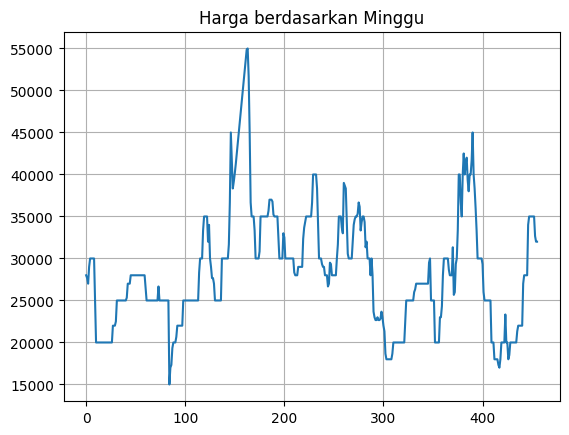

In [145]:
plt.plot(weekly_data['Harga/3 hari'])
plt.title('Harga berdasarkan Minggu')
plt.grid(True)

In [ ]:
# weekly_data.to_csv("weekly_data.csv", index=False)

## Data Preparation

In [146]:
week = np.array(weekly_data["3 Hari"])
series = np.array(weekly_data['Harga/3 hari'])
week.shape, series.shape

((456,), (456,))

In [147]:
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:(i + window_size)])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

In [148]:
def scaled_price(data):
    return data/1000

In [149]:
# Model configuration
window_size = 24

scaled_series = scaled_price(series)

X, y = create_sequences(scaled_series, window_size)

In [150]:
split_size1 = int(len(X) * 0.8)

week_train = week[:split_size1]
X_train = X[:split_size1]
y_train = y[:split_size1]

week_valid = week[split_size1:]
X_val = X[split_size1:]
y_val = y[split_size1:]
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((345, 24), (345,), (87, 24), (87,))

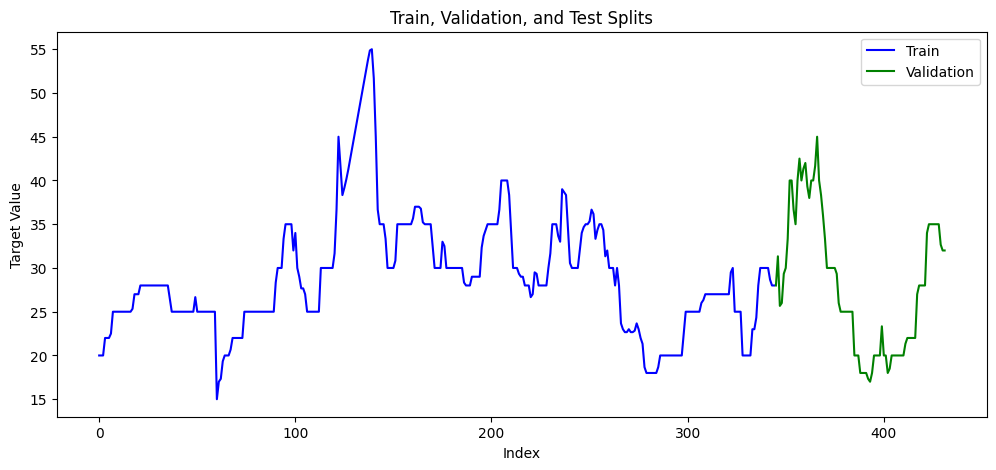

In [151]:
plt.figure(figsize=(12, 5))
plt.plot(np.arange(len(y_train)), y_train, label='Train', color='blue')
plt.plot(np.arange(len(y_train), len(y_train) + len(y_val)), y_val, label='Validation', color='green')

plt.xlabel('Index')
plt.ylabel('Target Value')
plt.legend()
plt.title('Train, Validation, and Test Splits')
plt.show()

## Train Model

### Model 1

In [152]:
def create_model(window_size):
    model = keras.Sequential([
        Input(shape=(window_size, 1)),
        Flatten(),
        # Dense(64, activation='relu'),
        Dense(128, activation='relu'),
        Dense(32, activation='relu'),
        Dense(1, activation='linear')
    ])
    return model

In [153]:
model_uncomplete = create_model(window_size)

model_uncomplete.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_3 (Flatten)                  │ (None, 24)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 128)                 │           3,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

### Find lr

In [154]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.Adam()

# Set the training parameters
model_uncomplete.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model_uncomplete.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=140, batch_size=4, callbacks=[lr_schedule])

Epoch 1/140
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 18.8731 - val_loss: 18.4831 - learning_rate: 1.0000e-08
Epoch 2/140
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 18.3391 - val_loss: 18.4780 - learning_rate: 1.1220e-08
Epoch 3/140
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 18.9227 - val_loss: 18.4722 - learning_rate: 1.2589e-08
Epoch 4/140
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 19.1130 - val_loss: 18.4660 - learning_rate: 1.4125e-08
Epoch 5/140
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 18.8232 - val_loss: 18.4597 - learning_rate: 1.5849e-08
Epoch 6/140
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 18.4563 - val_loss: 18.4529 - learning_rate: 1.7783e-08
Epoch 7/140
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 19.1566 - val_loss: 18.4452 - learning_rate: 1.9953e-08
Epoch 8/140
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 18.8289 - val_loss: 18.4362 - learning_rate: 2.2387e-08
Epoch 9/140
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 18.9042 - val_loss: 1

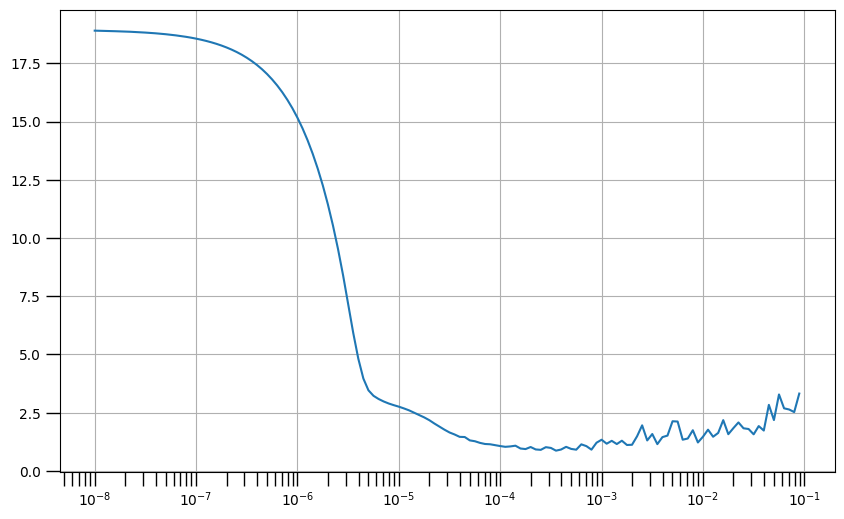

In [155]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(140) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
# plt.axis([1e-8, 1e-3, 0, 50])

### fit model 1

In [156]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        # Check the loss
        if logs['val_loss'] < 1:
            # Stop if threshold is met
            print("\Validation loss is lower than 1 so cancelling training!")
            self.model.stop_training = True

In [157]:
# Training Parameters
model = create_model(window_size)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0251)
model.compile(optimizer=optimizer, loss=tf.keras.losses.Huber())

In [158]:
# Model Training
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=500, batch_size=24, verbose=1, callbacks=[myCallback()])

Epoch 1/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 55.0429 - val_loss: 14.1760
Epoch 2/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.8304 - val_loss: 5.6084
Epoch 3/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.7318 - val_loss: 5.0429
Epoch 4/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.3253 - val_loss: 4.6026
Epoch 5/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.1879 - val_loss: 3.7187
Epoch 6/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.8040 - val_loss: 3.7889
Epoch 7/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.9733 - val_loss: 2.7197
Epoch 8/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.2332 - val_loss: 2.1836
Epoch 9/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.7679 - val_loss: 1.7015
Epoch 10/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.4409 - val_loss: 1.6826
Epoch 11/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.5310 - val_loss: 1.6399
Epoch 12/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss:

### Visualisasi loss

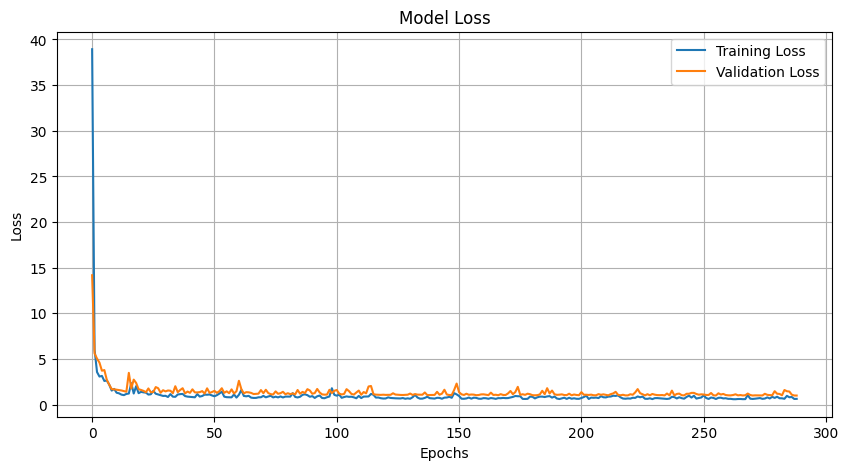

In [159]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Regularization (L2 Regularization)
model = keras.Sequential()
model.add(LSTM(128, activation='relu', return_sequences=True, input_shape=(WINDOW_SIZE, 1), kernel_regularizer=l2(0.01)))
model.add(LSTM(128, activation='relu', return_sequences=True, kernel_regularizer=l2(0.01)))
model.add(LSTM(128, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dense(1))

## Forecast

### Train Forecast

In [160]:
def inverse_scale(data):
    return data*1000

In [161]:
predict = model.predict(X)
predict = inverse_scale(predict.flatten())
y_inverse = inverse_scale(y)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


In [162]:
predict.shape

(432,)

In [163]:
predict_result = pd.DataFrame(data={'Week':week[window_size:], 'Prediction':predict, 'actuals':y_inverse})
predict_result

,Week,Prediction,actuals
0,25,19731.273438,20000.000000
1,26,19738.548828,20000.000000
2,27,20118.285156,20000.000000
3,28,20165.820312,22000.000000
4,29,22274.134766,22000.000000
...,...,...,...
427,452,35366.597656,35000.000000
428,453,34905.953125,35000.000000
429,454,34887.769531,32666.666667
430,455,32418.572266,32000.000000


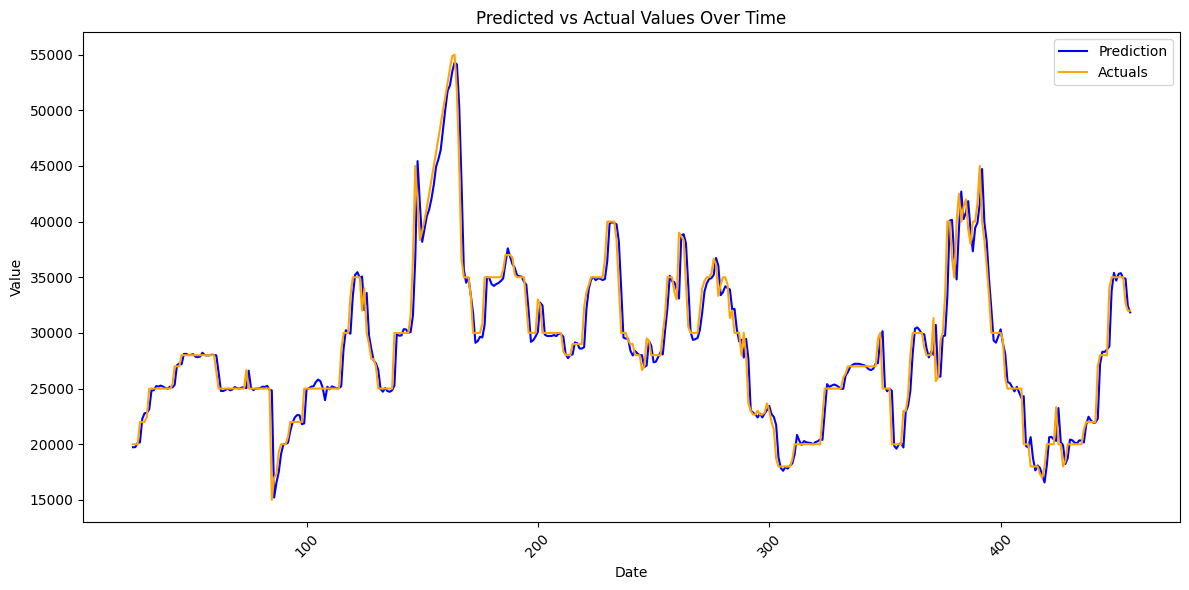

In [164]:
week_selected = 0
plt.figure(figsize=(12, 6))
plt.plot(predict_result['Week'][week_selected:], predict_result['Prediction'][week_selected:], label='Prediction', color='blue')
plt.plot(predict_result['Week'][week_selected:], predict_result['actuals'][week_selected:], label='Actuals', color='orange')

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Predicted vs Actual Values Over Time')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

### Validation Forecast

In [165]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_inverse, predict)
mse = mean_squared_error(y_inverse, predict)
rmse = np.sqrt(mse)

print(f'mae: {mae:.2f}')
print(f'mse: {mse:.2f}')
print(f'rmse: {rmse:.2f}')

mae: 968.09
mse: 2766945.06
rmse: 1663.41


In [166]:
mape = np.mean(np.abs((y_inverse - predict) / y_inverse)) * 100
accuracy = 100 - mape
print(f"Akurasi prediksi: {accuracy:.2f}%")

Akurasi prediksi: 96.68%


### Save Model

In [167]:
model.save('forecast_3hari_1.keras')

### Future Forecast

In [31]:
def inverse_scale(data):
    return data*1000

1. Load model

In [168]:
loaded_model = tf.keras.models.load_model('forecast_3hari_1.keras')

In [169]:
print(loaded_model.input_shape)

(None, 24, 1)


2. tes pakai data 30 index yang lalu

In [170]:
actual = series[:-30]
seq_res = np.array([])

In [171]:
series.shape

(456,)

In [172]:
act_temp = actual.reshape(-1, 1)

In [173]:
# data dibagi 1000
actual_scaled = scaled_price(act_temp)
# ambil 24 data terakhir
seq = actual_scaled[-window_size:]
# prediksi
hasil = loaded_model.predict(seq.reshape(1, window_size, 1))
# hasil prediksi dikali 1000
hasil = inverse_scale(hasil)
# hasil prediksi 3 hari pertama masuk ke variabell seq_res
seq_res = np.append(seq_res, hasil.item())
# hasil predksi masuk ke variabel pertama yang mengambil 24 data terakhir
act_temp = np.append(act_temp, np.expand_dims([hasil.item()], axis=1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


In [174]:
seq_res

array([19909.6171875])

In [175]:
actual_scaled = scaled_price(act_temp)
seq = actual_scaled[-window_size:]
hasil = loaded_model.predict(seq.reshape(1, window_size, 1))
hasil = inverse_scale(hasil)
seq_res = np.append(seq_res, hasil.item())
act_temp = np.append(act_temp, np.expand_dims([hasil.item()], axis=1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


3. Contoh hasil prediksi 6 hari(3 hari pertama dan 3 hari kedua)

In [176]:
seq_res

array([19909.6171875 , 20113.04882812])

4. harga asli selama 6 hari (3 hari pertama dan 3 hari kedua)

In [177]:
print(weekly_data[(weekly_data['3 Hari'] > 412) & (weekly_data['3 Hari'] <= 414)])

     3 Hari  Harga/3 hari
412     413       18000.0
413     414       18000.0


5. input data asli

In [178]:
actual = np.append(actual, [18000.00, 18000.00])

6. looping lagi

In [179]:
act_temp = actual.reshape(-1, 1)
# seq_res = np.array([])

In [180]:
actual_scaled = scaled_price(act_temp)
seq = actual_scaled[-window_size:]
hasil = loaded_model.predict(seq.reshape(1, window_size, 1))
hasil = inverse_scale(hasil)
seq_res = np.append(seq_res, hasil.item())
act_temp = np.append(act_temp, np.expand_dims([hasil.item()], axis=1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


In [181]:
seq_res

array([19909.6171875 , 20113.04882812, 18254.56640625])

In [182]:
actual_scaled = scaled_price(act_temp)
seq = actual_scaled[-window_size:]
hasil = loaded_model.predict(seq.reshape(1, window_size, 1))
hasil = inverse_scale(hasil)
seq_res = np.append(seq_res, hasil.item())
act_temp = np.append(act_temp, np.expand_dims([hasil.item()], axis=1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


In [183]:
seq_res

array([19909.6171875 , 20113.04882812, 18254.56640625, 18657.28710938])

In [184]:
print(weekly_data[(weekly_data['3 Hari'] > 414) & (weekly_data['3 Hari'] <= 416)])

     3 Hari  Harga/3 hari
414     415       18000.0
415     416       18000.0


In [185]:
actual = np.append(actual, [18000.00, 18000.00])

In [186]:
act_temp = actual.reshape(-1, 1)
# seq_res = np.array([])

In [187]:
actual_scaled = scaled_price(act_temp)
seq = actual_scaled[-window_size:]
hasil = loaded_model.predict(seq.reshape(1, window_size, 1))
hasil = inverse_scale(hasil)
seq_res = np.append(seq_res, hasil.item())
act_temp = np.append(act_temp, np.expand_dims([hasil.item()], axis=1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


In [188]:
seq_res

array([19909.6171875 , 20113.04882812, 18254.56640625, 18657.28710938,
       18275.51367188])

In [189]:
actual_scaled = scaled_price(act_temp)
seq = actual_scaled[-window_size:]
hasil = loaded_model.predict(seq.reshape(1, window_size, 1))
hasil = inverse_scale(hasil)
seq_res = np.append(seq_res, hasil.item())
act_temp = np.append(act_temp, np.expand_dims([hasil.item()], axis=1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


In [190]:
seq_res

array([19909.6171875 , 20113.04882812, 18254.56640625, 18657.28710938,
       18275.51367188, 18405.234375  ])

In [191]:
print(weekly_data[(weekly_data['3 Hari'] > 416) & (weekly_data['3 Hari'] <= 418)])

     3 Hari  Harga/3 hari
416     417  17333.333333
417     418  17000.000000


In [192]:
actual = np.append(actual, [17333.33, 17000.00])

In [193]:
act_temp = actual.reshape(-1, 1)
# seq_res = np.array([])

In [194]:
actual_scaled = scaled_price(act_temp)
seq = actual_scaled[-window_size:]
hasil = loaded_model.predict(seq.reshape(1, window_size, 1))
hasil = inverse_scale(hasil)
seq_res = np.append(seq_res, hasil.item())
act_temp = np.append(act_temp, np.expand_dims([hasil.item()], axis=1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


In [195]:
seq_res

array([19909.6171875 , 20113.04882812, 18254.56640625, 18657.28710938,
       18275.51367188, 18405.234375  , 16988.453125  ])

In [196]:
actual_scaled = scaled_price(act_temp)
seq = actual_scaled[-window_size:]
hasil = loaded_model.predict(seq.reshape(1, window_size, 1))
hasil = inverse_scale(hasil)
seq_res = np.append(seq_res, hasil.item())
act_temp = np.append(act_temp, np.expand_dims([hasil.item()], axis=1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


In [197]:
seq_res

array([19909.6171875 , 20113.04882812, 18254.56640625, 18657.28710938,
       18275.51367188, 18405.234375  , 16988.453125  , 17277.4765625 ])

In [198]:
print(weekly_data[(weekly_data['3 Hari'] > 418) & (weekly_data['3 Hari'] <= 420)])

     3 Hari  Harga/3 hari
418     419       18000.0
419     420       20000.0


In [199]:
actual = np.append(actual, [18000.00, 20000.00])

In [200]:
act_temp = actual.reshape(-1, 1)
# seq_res = np.array([])

In [201]:
actual_scaled = scaled_price(act_temp)
seq = actual_scaled[-window_size:]
hasil = loaded_model.predict(seq.reshape(1, window_size, 1))
hasil = inverse_scale(hasil)
seq_res = np.append(seq_res, hasil.item())
act_temp = np.append(act_temp, np.expand_dims([hasil.item()], axis=1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


In [202]:
seq_res

array([19909.6171875 , 20113.04882812, 18254.56640625, 18657.28710938,
       18275.51367188, 18405.234375  , 16988.453125  , 17277.4765625 ,
       20326.78125   ])

In [203]:
actual_scaled = scaled_price(act_temp)
seq = actual_scaled[-window_size:]
hasil = loaded_model.predict(seq.reshape(1, window_size, 1))
hasil = inverse_scale(hasil)
seq_res = np.append(seq_res, hasil.item())
act_temp = np.append(act_temp, np.expand_dims([hasil.item()], axis=1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


In [204]:
seq_res

array([19909.6171875 , 20113.04882812, 18254.56640625, 18657.28710938,
       18275.51367188, 18405.234375  , 16988.453125  , 17277.4765625 ,
       20326.78125   , 20595.91015625])

In [205]:
print(weekly_data[(weekly_data['3 Hari'] > 420) & (weekly_data['3 Hari'] <= 422)])

     3 Hari  Harga/3 hari
420     421       20000.0
421     422       20000.0


In [206]:
actual = np.append(actual, [20000.00, 20000.14])

In [207]:
act_temp = actual.reshape(-1, 1)
# seq_res = np.array([])

In [208]:
actual_scaled = scaled_price(act_temp)
seq = actual_scaled[-window_size:]
hasil = loaded_model.predict(seq.reshape(1, window_size, 1))
hasil = inverse_scale(hasil)
seq_res = np.append(seq_res, hasil.item())
act_temp = np.append(act_temp, np.expand_dims([hasil.item()], axis=1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


In [209]:
seq_res

array([19909.6171875 , 20113.04882812, 18254.56640625, 18657.28710938,
       18275.51367188, 18405.234375  , 16988.453125  , 17277.4765625 ,
       20326.78125   , 20595.91015625, 20529.375     ])

In [210]:
actual_scaled = scaled_price(act_temp)
seq = actual_scaled[-window_size:]
hasil = loaded_model.predict(seq.reshape(1, window_size, 1))
hasil = inverse_scale(hasil)
seq_res = np.append(seq_res, hasil.item())
act_temp = np.append(act_temp, np.expand_dims([hasil.item()], axis=1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


In [211]:
seq_res

array([19909.6171875 , 20113.04882812, 18254.56640625, 18657.28710938,
       18275.51367188, 18405.234375  , 16988.453125  , 17277.4765625 ,
       20326.78125   , 20595.91015625, 20529.375     , 21022.421875  ])

In [212]:
print(weekly_data[(weekly_data['3 Hari'] > 422) & (weekly_data['3 Hari'] <= 424)])

     3 Hari  Harga/3 hari
422     423  20000.000000
423     424  23333.333333


In [213]:
actual = np.append(actual, [20000.00, 23333.00])

In [214]:
act_temp = actual.reshape(-1, 1)
# seq_res = np.array([])

In [215]:
actual_scaled = scaled_price(act_temp)
seq = actual_scaled[-window_size:]
hasil = loaded_model.predict(seq.reshape(1, window_size, 1))
hasil = inverse_scale(hasil)
seq_res = np.append(seq_res, hasil.item())
act_temp = np.append(act_temp, np.expand_dims([hasil.item()], axis=1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


In [216]:
seq_res

array([19909.6171875 , 20113.04882812, 18254.56640625, 18657.28710938,
       18275.51367188, 18405.234375  , 16988.453125  , 17277.4765625 ,
       20326.78125   , 20595.91015625, 20529.375     , 21022.421875  ,
       23569.87890625])

In [217]:
actual_scaled = scaled_price(act_temp)
seq = actual_scaled[-window_size:]
hasil = loaded_model.predict(seq.reshape(1, window_size, 1))
hasil = inverse_scale(hasil)
seq_res = np.append(seq_res, hasil.item())
act_temp = np.append(act_temp, np.expand_dims([hasil.item()], axis=1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


In [218]:
seq_res

array([19909.6171875 , 20113.04882812, 18254.56640625, 18657.28710938,
       18275.51367188, 18405.234375  , 16988.453125  , 17277.4765625 ,
       20326.78125   , 20595.91015625, 20529.375     , 21022.421875  ,
       23569.87890625, 23815.62304688])

In [219]:
print(weekly_data[(weekly_data['3 Hari'] > 424) & (weekly_data['3 Hari'] <= 426)])

     3 Hari  Harga/3 hari
424     425       20000.0
425     426       20000.0


In [220]:
actual = np.append(actual, [20000.00, 20000.00])

In [221]:
act_temp = actual.reshape(-1, 1)
# seq_res = np.array([])

In [222]:
actual_scaled = scaled_price(act_temp)
seq = actual_scaled[-window_size:]
hasil = loaded_model.predict(seq.reshape(1, window_size, 1))
hasil = inverse_scale(hasil)
seq_res = np.append(seq_res, hasil.item())
act_temp = np.append(act_temp, np.expand_dims([hasil.item()], axis=1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


In [223]:
seq_res

array([19909.6171875 , 20113.04882812, 18254.56640625, 18657.28710938,
       18275.51367188, 18405.234375  , 16988.453125  , 17277.4765625 ,
       20326.78125   , 20595.91015625, 20529.375     , 21022.421875  ,
       23569.87890625, 23815.62304688, 19766.70117188])

In [224]:
actual_scaled = scaled_price(act_temp)
seq = actual_scaled[-window_size:]
hasil = loaded_model.predict(seq.reshape(1, window_size, 1))
hasil = inverse_scale(hasil)
seq_res = np.append(seq_res, hasil.item())
act_temp = np.append(act_temp, np.expand_dims([hasil.item()], axis=1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


In [225]:
seq_res

array([19909.6171875 , 20113.04882812, 18254.56640625, 18657.28710938,
       18275.51367188, 18405.234375  , 16988.453125  , 17277.4765625 ,
       20326.78125   , 20595.91015625, 20529.375     , 21022.421875  ,
       23569.87890625, 23815.62304688, 19766.70117188, 20078.78125   ])

In [226]:
print(weekly_data[(weekly_data['3 Hari'] > 426) & (weekly_data['3 Hari'] <= 428)])

     3 Hari  Harga/3 hari
426     427       18000.0
427     428       18500.0


In [227]:
actual = np.append(actual, [18000.00, 18500.00])

In [228]:
act_temp = actual.reshape(-1, 1)
# seq_res = np.array([])

In [229]:
actual_scaled = scaled_price(act_temp)
seq = actual_scaled[-window_size:]
hasil = loaded_model.predict(seq.reshape(1, window_size, 1))
hasil = inverse_scale(hasil)
seq_res = np.append(seq_res, hasil.item())
act_temp = np.append(act_temp, np.expand_dims([hasil.item()], axis=1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


In [230]:
seq_res

array([19909.6171875 , 20113.04882812, 18254.56640625, 18657.28710938,
       18275.51367188, 18405.234375  , 16988.453125  , 17277.4765625 ,
       20326.78125   , 20595.91015625, 20529.375     , 21022.421875  ,
       23569.87890625, 23815.62304688, 19766.70117188, 20078.78125   ,
       18670.0859375 ])

In [231]:
actual_scaled = scaled_price(act_temp)
seq = actual_scaled[-window_size:]
hasil = loaded_model.predict(seq.reshape(1, window_size, 1))
hasil = inverse_scale(hasil)
seq_res = np.append(seq_res, hasil.item())
act_temp = np.append(act_temp, np.expand_dims([hasil.item()], axis=1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


In [232]:
seq_res

array([19909.6171875 , 20113.04882812, 18254.56640625, 18657.28710938,
       18275.51367188, 18405.234375  , 16988.453125  , 17277.4765625 ,
       20326.78125   , 20595.91015625, 20529.375     , 21022.421875  ,
       23569.87890625, 23815.62304688, 19766.70117188, 20078.78125   ,
       18670.0859375 , 18673.125     ])

In [233]:
print(weekly_data[(weekly_data['3 Hari'] > 428) & (weekly_data['3 Hari'] <= 430)])

     3 Hari  Harga/3 hari
428     429       20000.0
429     430       20000.0


In [234]:
actual = np.append(actual, [20000.00, 20000.00])

In [235]:
act_temp = actual.reshape(-1, 1)
# seq_res = np.array([])

In [236]:
actual_scaled = scaled_price(act_temp)
seq = actual_scaled[-window_size:]
hasil = loaded_model.predict(seq.reshape(1, window_size, 1))
hasil = inverse_scale(hasil)
seq_res = np.append(seq_res, hasil.item())
act_temp = np.append(act_temp, np.expand_dims([hasil.item()], axis=1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


In [237]:
seq_res

array([19909.6171875 , 20113.04882812, 18254.56640625, 18657.28710938,
       18275.51367188, 18405.234375  , 16988.453125  , 17277.4765625 ,
       20326.78125   , 20595.91015625, 20529.375     , 21022.421875  ,
       23569.87890625, 23815.62304688, 19766.70117188, 20078.78125   ,
       18670.0859375 , 18673.125     , 20096.2109375 ])

In [238]:
actual_scaled = scaled_price(act_temp)
seq = actual_scaled[-window_size:]
hasil = loaded_model.predict(seq.reshape(1, window_size, 1))
hasil = inverse_scale(hasil)
seq_res = np.append(seq_res, hasil.item())
act_temp = np.append(act_temp, np.expand_dims([hasil.item()], axis=1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


In [239]:
seq_res

array([19909.6171875 , 20113.04882812, 18254.56640625, 18657.28710938,
       18275.51367188, 18405.234375  , 16988.453125  , 17277.4765625 ,
       20326.78125   , 20595.91015625, 20529.375     , 21022.421875  ,
       23569.87890625, 23815.62304688, 19766.70117188, 20078.78125   ,
       18670.0859375 , 18673.125     , 20096.2109375 , 20263.09765625])

In [240]:
print(weekly_data[(weekly_data['3 Hari'] > 430) & (weekly_data['3 Hari'] <= 432)])

     3 Hari  Harga/3 hari
430     431       20000.0
431     432       20000.0


In [241]:
actual = np.append(actual, [20000.00, 20000.00])

In [242]:
act_temp = actual.reshape(-1, 1)
# seq_res = np.array([])

In [243]:
actual_scaled = scaled_price(act_temp)
seq = actual_scaled[-window_size:]
hasil = loaded_model.predict(seq.reshape(1, window_size, 1))
hasil = inverse_scale(hasil)
seq_res = np.append(seq_res, hasil.item())
act_temp = np.append(act_temp, np.expand_dims([hasil.item()], axis=1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


In [244]:
seq_res

array([19909.6171875 , 20113.04882812, 18254.56640625, 18657.28710938,
       18275.51367188, 18405.234375  , 16988.453125  , 17277.4765625 ,
       20326.78125   , 20595.91015625, 20529.375     , 21022.421875  ,
       23569.87890625, 23815.62304688, 19766.70117188, 20078.78125   ,
       18670.0859375 , 18673.125     , 20096.2109375 , 20263.09765625,
       20994.34960938])

In [245]:
actual_scaled = scaled_price(act_temp)
seq = actual_scaled[-window_size:]
hasil = loaded_model.predict(seq.reshape(1, window_size, 1))
hasil = inverse_scale(hasil)
seq_res = np.append(seq_res, hasil.item())
act_temp = np.append(act_temp, np.expand_dims([hasil.item()], axis=1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


In [246]:
seq_res

array([19909.6171875 , 20113.04882812, 18254.56640625, 18657.28710938,
       18275.51367188, 18405.234375  , 16988.453125  , 17277.4765625 ,
       20326.78125   , 20595.91015625, 20529.375     , 21022.421875  ,
       23569.87890625, 23815.62304688, 19766.70117188, 20078.78125   ,
       18670.0859375 , 18673.125     , 20096.2109375 , 20263.09765625,
       20994.34960938, 20980.8046875 ])

In [247]:
print(weekly_data[(weekly_data['3 Hari'] > 432) & (weekly_data['3 Hari'] <= 434)])

     3 Hari  Harga/3 hari
432     433       20000.0
433     434       20000.0


In [248]:
actual = np.append(actual, [20000.00, 20000.00])

In [249]:
act_temp = actual.reshape(-1, 1)
# seq_res = np.array([])

In [250]:
actual_scaled = scaled_price(act_temp)
seq = actual_scaled[-window_size:]
hasil = loaded_model.predict(seq.reshape(1, window_size, 1))
hasil = inverse_scale(hasil)
seq_res = np.append(seq_res, hasil.item())
act_temp = np.append(act_temp, np.expand_dims([hasil.item()], axis=1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


In [251]:
seq_res

array([19909.6171875 , 20113.04882812, 18254.56640625, 18657.28710938,
       18275.51367188, 18405.234375  , 16988.453125  , 17277.4765625 ,
       20326.78125   , 20595.91015625, 20529.375     , 21022.421875  ,
       23569.87890625, 23815.62304688, 19766.70117188, 20078.78125   ,
       18670.0859375 , 18673.125     , 20096.2109375 , 20263.09765625,
       20994.34960938, 20980.8046875 , 20326.19921875])

In [252]:
actual_scaled = scaled_price(act_temp)
seq = actual_scaled[-window_size:]
hasil = loaded_model.predict(seq.reshape(1, window_size, 1))
hasil = inverse_scale(hasil)
seq_res = np.append(seq_res, hasil.item())
act_temp = np.append(act_temp, np.expand_dims([hasil.item()], axis=1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


In [253]:
seq_res

array([19909.6171875 , 20113.04882812, 18254.56640625, 18657.28710938,
       18275.51367188, 18405.234375  , 16988.453125  , 17277.4765625 ,
       20326.78125   , 20595.91015625, 20529.375     , 21022.421875  ,
       23569.87890625, 23815.62304688, 19766.70117188, 20078.78125   ,
       18670.0859375 , 18673.125     , 20096.2109375 , 20263.09765625,
       20994.34960938, 20980.8046875 , 20326.19921875, 20481.67578125])

In [254]:
print(weekly_data[(weekly_data['3 Hari'] > 434) & (weekly_data['3 Hari'] <= 436)])

     3 Hari  Harga/3 hari
434     435  20000.000000
435     436  21333.333333


In [255]:
actual = np.append(actual, [20000.00, 21333.33])

In [256]:
act_temp = actual.reshape(-1, 1)
# seq_res = np.array([])

In [257]:
actual_scaled = scaled_price(act_temp)
seq = actual_scaled[-window_size:]
hasil = loaded_model.predict(seq.reshape(1, window_size, 1))
hasil = inverse_scale(hasil)
seq_res = np.append(seq_res, hasil.item())
act_temp = np.append(act_temp, np.expand_dims([hasil.item()], axis=1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


In [258]:
actual_scaled = scaled_price(act_temp)
seq = actual_scaled[-window_size:]
hasil = loaded_model.predict(seq.reshape(1, window_size, 1))
hasil = inverse_scale(hasil)
seq_res = np.append(seq_res, hasil.item())
act_temp = np.append(act_temp, np.expand_dims([hasil.item()], axis=1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


In [259]:
seq_res

array([19909.6171875 , 20113.04882812, 18254.56640625, 18657.28710938,
       18275.51367188, 18405.234375  , 16988.453125  , 17277.4765625 ,
       20326.78125   , 20595.91015625, 20529.375     , 21022.421875  ,
       23569.87890625, 23815.62304688, 19766.70117188, 20078.78125   ,
       18670.0859375 , 18673.125     , 20096.2109375 , 20263.09765625,
       20994.34960938, 20980.8046875 , 20326.19921875, 20481.67578125,
       21755.98046875, 22231.39257812])

In [260]:
print(weekly_data[(weekly_data['3 Hari'] > 436) & (weekly_data['3 Hari'] <= 438)])

     3 Hari  Harga/3 hari
436     437       22000.0
437     438       22000.0


In [261]:
actual = np.append(actual, [22000.00, 22000.00])

In [262]:
act_temp = actual.reshape(-1, 1)
# seq_res = np.array([])

In [263]:
actual_scaled = scaled_price(act_temp)
seq = actual_scaled[-window_size:]
hasil = loaded_model.predict(seq.reshape(1, window_size, 1))
hasil = inverse_scale(hasil)
seq_res = np.append(seq_res, hasil.item())
act_temp = np.append(act_temp, np.expand_dims([hasil.item()], axis=1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


In [264]:
actual_scaled = scaled_price(act_temp)
seq = actual_scaled[-window_size:]
hasil = loaded_model.predict(seq.reshape(1, window_size, 1))
hasil = inverse_scale(hasil)
seq_res = np.append(seq_res, hasil.item())
act_temp = np.append(act_temp, np.expand_dims([hasil.item()], axis=1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


In [265]:
seq_res

array([19909.6171875 , 20113.04882812, 18254.56640625, 18657.28710938,
       18275.51367188, 18405.234375  , 16988.453125  , 17277.4765625 ,
       20326.78125   , 20595.91015625, 20529.375     , 21022.421875  ,
       23569.87890625, 23815.62304688, 19766.70117188, 20078.78125   ,
       18670.0859375 , 18673.125     , 20096.2109375 , 20263.09765625,
       20994.34960938, 20980.8046875 , 20326.19921875, 20481.67578125,
       21755.98046875, 22231.39257812, 22145.68945312, 22086.52734375])

In [266]:
print(weekly_data[(weekly_data['3 Hari'] > 438) & (weekly_data['3 Hari'] <= 440)])

     3 Hari  Harga/3 hari
438     439       22000.0
439     440       22000.0


In [267]:
actual = np.append(actual, [22000.00, 22000.00])

In [268]:
act_temp = actual.reshape(-1, 1)
# seq_res = np.array([])

In [269]:
actual_scaled = scaled_price(act_temp)
seq = actual_scaled[-window_size:]
hasil = loaded_model.predict(seq.reshape(1, window_size, 1))
hasil = inverse_scale(hasil)
seq_res = np.append(seq_res, hasil.item())
act_temp = np.append(act_temp, np.expand_dims([hasil.item()], axis=1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


In [270]:
actual_scaled = scaled_price(act_temp)
seq = actual_scaled[-window_size:]
hasil = loaded_model.predict(seq.reshape(1, window_size, 1))
hasil = inverse_scale(hasil)
seq_res = np.append(seq_res, hasil.item())
act_temp = np.append(act_temp, np.expand_dims([hasil.item()], axis=1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


In [271]:
seq_res

array([19909.6171875 , 20113.04882812, 18254.56640625, 18657.28710938,
       18275.51367188, 18405.234375  , 16988.453125  , 17277.4765625 ,
       20326.78125   , 20595.91015625, 20529.375     , 21022.421875  ,
       23569.87890625, 23815.62304688, 19766.70117188, 20078.78125   ,
       18670.0859375 , 18673.125     , 20096.2109375 , 20263.09765625,
       20994.34960938, 20980.8046875 , 20326.19921875, 20481.67578125,
       21755.98046875, 22231.39257812, 22145.68945312, 22086.52734375,
       21949.90625   , 22245.44335938])

In [272]:
seq_res.shape

(30,)

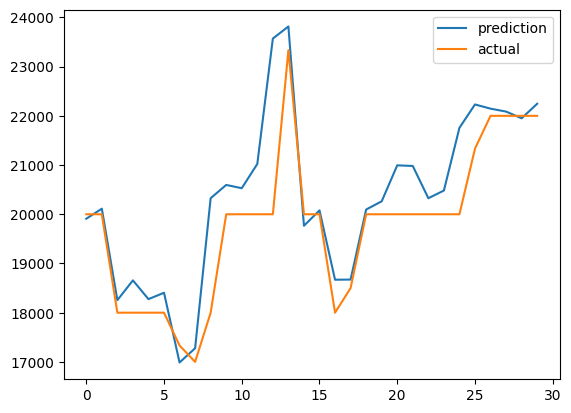

In [273]:
plt.plot(seq_res, label='prediction')
plt.plot(actual[-30:], label='actual')
plt.legend()

In [274]:
mae = mean_absolute_error(seq_res, actual[-30:])
mse = mean_squared_error(seq_res, actual[-30:])
rmse = np.sqrt(mse)

print(f'mae: {mae:.2f}')
print(f'mse: {mse:.2f}')
print(f'rmse: {rmse:.2f}')

mae: 614.16
mse: 930459.59
rmse: 964.60


In [275]:
mape = np.mean(np.abs((seq_res - actual[-30:]) / seq_res)) * 100
accuracy = 100 - mape
print(f"Akurasi prediksi: {accuracy:.2f}%")

Akurasi prediksi: 97.07%


## Deploy Model

export ke tflite kalo di bawah

In [ ]:
export_dir = 'saved_model/1'

tf.saved_model.save(model, export_dir)

In [ ]:
# Select mode of optimization
mode = "Default" 

if mode == 'Storage':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_SIZE
elif mode == 'Speed':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_LATENCY
else:
    optimization = tf.lite.Optimize.DEFAULT

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)

# Set the optimzations
converter.optimizations = [optimization]

# Invoke the converter to finally generate the TFLite model
tflite_model = converter.convert();

In [ ]:
import pathlib

tflite_model_file = pathlib.Path('./model.tflite')
tflite_model_file.write_bytes(tflite_model)

## Load Model

In [ ]:
# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]